<a href="https://colab.research.google.com/github/cloverbunny/mimic-iv/blob/master/c14_combine_mimic_files3_20_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cleaning mimic files so far into one notebook

Notes from Notebook on how to run bigquery in colab - https://github.com/MIT-LCP/mimic-code/discussions/1154

# Setup

Load libraries and connect to the data

Run the following cells to import some libraries and then connect to the database.

In [2]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import seaborn as sns

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# mount google drive to save files separately
from google.colab import drive

In [27]:
auth.authenticate_user()

In [28]:
project_id='prismatic-fact-272817'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/

/content/drive/My Drive


# Getting intubated patients who stayed in MICU units (includes units that are MICU/SICU)

[BigQuery syntax](https://googleapis.dev/python/bigquery/latest/magics.html).

In [ ]:
%%bigquery vented

select *
from `physionet-data.mimic_derived.ventilation` v join  `physionet-data.mimic_icu.icustays` icus on v.stay_id = icus.stay_id
where ventilation_status like 'InvasiveVent'
AND
  first_careunit LIKE '%MICU%'
  AND last_careunit LIKE '%MICU%'


In [ ]:
vented.shape

(10915, 12)

In [ ]:
vented.head()

stay_id           starttime             endtime ventilation_status  \
0  31326208 2135-06-20 23:18:00 2135-06-22 01:00:00       InvasiveVent   
1  31004416 2120-02-09 11:00:00 2120-02-10 08:00:00       InvasiveVent   
2  31004416 2120-02-24 03:00:00 2120-02-24 15:00:00       InvasiveVent   
3  31004416 2120-02-12 15:00:00 2120-02-13 12:40:00       InvasiveVent   
4  31004416 2120-02-06 21:39:00 2120-02-07 08:00:00       InvasiveVent   

   subject_id   hadm_id  stay_id_1  \
0    19120385  23418362   31326208   
1    13390728  26350081   31004416   
2    13390728  26350081   31004416   
3    13390728  26350081   31004416   
4    13390728  26350081   31004416   

                                     first_careunit  \
0                Medical Intensive Care Unit (MICU)   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)   
2  Medical/Surgical Intensive Care Unit (MICU/SICU)   
3  Medical/Surgical Intensive Care Unit (MICU/SICU)   
4  Medical/Surgical Intensive Care Unit (MICU/SICU)   

                                      last_careunit              intime  \
0                Medical Intensive Care Unit (MICU) 2135-06-20 23:00:00   
1  Medical/Surgical Intensive Care Unit (MICU/SICU) 2120-02-06 20:55:28   
2  Medical/Surgical Intensive Care Unit (MICU/SICU) 2120-02-06 20:55:28   
3  Medical/Surgical Intensive Care Unit (MICU/SICU) 2120-02-06 20:55:28   
4  Medical/Surgical Intensive Care Unit (MICU/SICU) 2120-02-06 20:55:28   

              outtime        los  
0 2135-06-22 06:02:12   1.293194  
1 2120-02-29 21:46:04  23.035139  
2 2120-02-29 21:46:04  23.035139  
3 2120-02-29 21:46:04  23.035139  
4 2120-02-29 21:46:04  23.035139

In [ ]:
vented_unique = vented.drop_duplicates(subset=["hadm_id"])

In [ ]:
vented_unique.shape

(7042, 12)

## Getting pneumonia patients

In [ ]:
%%bigquery pneumonia

SELECT *
from `physionet-data.mimic_hosp.diagnoses_icd` dx
join `physionet-data.mimic_hosp.d_icd_diagnoses` icd
    on dx.icd_code=icd.icd_code
where icd.long_title LIKE '%pneumonia%'

In [ ]:
pneumonia.head()

subject_id   hadm_id  seq_num icd_code  icd_version icd_code_1  \
0    17967970  21746242       31     B953           10       B953   
1    18622276  20636275       25     B953           10       B953   
2    13610988  25620263       31    J1289           10      J1289   
3    10011849  20188892       36     B953           10       B953   
4    12227782  29222288        1    48249            9      48249   

   icd_version_1                                         long_title  
0             10  Streptococcus pneumoniae as the cause of disea...  
1             10  Streptococcus pneumoniae as the cause of disea...  
2             10                              Other viral pneumonia  
3             10  Streptococcus pneumoniae as the cause of disea...  
4              9                     Other Staphylococcus pneumonia

In [ ]:
pneumonia.shape

(10673, 8)

In [ ]:
len(pneumonia.subject_id.unique())

8584

In [ ]:
len(pneumonia.hadm_id.unique())

9999

In [ ]:
pneumonia.long_title.value_counts()

Ventilator associated pneumonia                                                                                           1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                                       1425
Personal history of pneumonia (recurrent)                                                                                 1208
Bacterial pneumonia, unspecified                                                                                          1093
Other specified vaccinations against streptococcus pneumoniae [pneumococcus]                                              1007
Unspecified bacterial pneumonia                                                                                            716
Methicillin resistant pneumonia due to Staphylococcus aureus                                                               346
Methicillin susceptible pneumonia due to Staphylococcus aureus                                                 

In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
names_to_remove = [
    'Other specified vaccinations against streptococcus pneumoniae [pneumococcus]',
    'Need for prophylactic vaccination and inoculation against streptococcus pneumoniae [pneumococcus] and influenza',
    'Cryptogenic organizing pneumonia',
    'Congenital pneumonia',
    'Abscess of lung without pneumonia',    
    'Congenital pneumonia, unspecified',
    'Congenital pneumonia due to staphylococcus',
    'Idiopathic interstitial pneumonia, not otherwise specified',
    'Congenital pneumonia due to other bacterial agents',
    'Desquamative interstitial pneumonia',
    'Congenital pneumonia due to Escherichia coli',
    'Infection by Histoplasma capsulatum, pneumonia',
    'Tuberculous pneumonia [any form], tubercle bacilli found (in sputum) by microscopy',
    'Whooping cough, unspecified species without pneumonia',
    'Congenital pneumonia due to Pseudomonas',
    'Congenital pneumonia due to viral agent',
    'Hypostatic pneumonia, unspecified organism',
    'Lymphoid interstitial pneumonia',
    'Congenital pneumonia due to streptococcus, group B',
    'Tuberculous pneumonia [any form], tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture',
    'Tuberculous pneumonia [any form], unspecified',  
    'Idiopathic lymphoid interstitial pneumonia'  
]

In [ ]:
pneumonia_clean= pneumonia[~pneumonia['long_title'].isin(names_to_remove)]

In [ ]:
pneumonia_clean.long_title.value_counts()

Ventilator associated pneumonia                                                                               1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                           1425
Personal history of pneumonia (recurrent)                                                                     1208
Bacterial pneumonia, unspecified                                                                              1093
Unspecified bacterial pneumonia                                                                                716
Methicillin resistant pneumonia due to Staphylococcus aureus                                                   346
Methicillin susceptible pneumonia due to Staphylococcus aureus                                                 341
Pneumonia due to Klebsiella pneumoniae                                                                         276
Influenza with pneumonia                                                        

In [ ]:
pneumonia_clean.shape

(9084, 8)

In [ ]:
len(pneumonia_clean.hadm_id.unique())

8459

In [ ]:
pneumonia_short = pneumonia_clean.drop_duplicates(subset=["hadm_id"])

In [ ]:
pneumonia_short.shape

(8459, 8)

# Merging pneumonia and vented MICU patients

In [ ]:
micuventpneumonia = vented_unique.merge(pneumonia_short, how='inner', on='hadm_id', indicator=True)

In [ ]:
micuventpneumonia.head()

stay_id           starttime             endtime ventilation_status  \
0  31004416 2120-02-09 11:00:00 2120-02-10 08:00:00       InvasiveVent   
1  39008512 2136-09-14 21:00:00 2136-09-15 00:00:00       InvasiveVent   
2  31813120 2151-05-25 14:00:00 2151-05-26 16:45:00       InvasiveVent   
3  32863488 2171-06-04 10:00:00 2171-06-11 13:00:00       InvasiveVent   
4  35174400 2166-03-15 10:00:00 2166-03-19 07:00:00       InvasiveVent   

   subject_id_x   hadm_id  stay_id_1  \
0      13390728  26350081   31004416   
1      17521905  29059095   39008512   
2      18081075  28510423   31813120   
3      17914766  24743178   32863488   
4      13870531  23854031   35174400   

                                     first_careunit  \
0  Medical/Surgical Intensive Care Unit (MICU/SICU)   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)   
2                Medical Intensive Care Unit (MICU)   
3                Medical Intensive Care Unit (MICU)   
4  Medical/Surgical Intensive Care Unit (MICU/SICU)   

                                      last_careunit              intime  \
0  Medical/Surgical Intensive Care Unit (MICU/SICU) 2120-02-06 20:55:28   
1  Medical/Surgical Intensive Care Unit (MICU/SICU) 2136-09-02 15:09:45   
2                Medical Intensive Care Unit (MICU) 2151-05-25 14:13:00   
3                Medical Intensive Care Unit (MICU) 2171-06-04 10:32:22   
4  Medical/Surgical Intensive Care Unit (MICU/SICU) 2166-03-10 19:01:30   

              outtime        los  subject_id_y  seq_num icd_code  icd_version  \
0 2120-02-29 21:46:04  23.035139      13390728        8     J181           10   
1 2136-09-23 21:30:42  21.264549      17521905        8   J95851           10   
2 2151-06-07 14:32:42  13.013681      18081075        1    J1000           10   
3 2171-06-17 22:30:20  13.498588      17914766        7   J95851           10   
4 2166-03-29 18:25:59  18.975336      13870531        5     4870            9   

  icd_code_1  icd_version_1  \
0       J181             10   
1     J95851             10   
2      J1000             10   
3     J95851             10   
4       4870              9   

                                          long_title _merge  
0              Lobar pneumonia, unspecified organism   both  
1                    Ventilator associated pneumonia   both  
2  Influenza due to other identified influenza vi...   both  
3                    Ventilator associated pneumonia   both  
4                           Influenza with pneumonia   both

In [ ]:
micuventpneumonia.shape

(1284, 20)

In [ ]:
micuventpneumonia.to_csv("micuventpneumonia3-20-22.csv")

# Patients who had respiratory samples


In [ ]:
%%bigquery respsamples

select hadm_id
from `physionet-data.mimic_hosp.microbiologyevents`
where spec_type_desc in 
("BRONCHOALVEOLAR LAVAGE",
"Mini-BAL",
"TRACHEAL ASPIRATE",
"BRONCHIAL WASHINGS",
"Rapid Respiratory Viral Screen & Culture"
)
    AND hadm_id is not NULL
group by hadm_id

In [ ]:
respsamples.shape

(10603, 1)

In [ ]:
#micu vent + samples
micuventsample = vented_unique.merge(respsamples, how='inner', on='hadm_id', indicator=True)

In [ ]:
micuventsample.shape

(1859, 13)

In [ ]:
micuventsample.head()

stay_id           starttime             endtime ventilation_status  \
0  31004416 2120-02-09 11:00:00 2120-02-10 08:00:00       InvasiveVent   
1  39663616 2117-01-02 20:00:00 2117-01-04 12:00:00       InvasiveVent   
2  39008512 2136-09-14 21:00:00 2136-09-15 00:00:00       InvasiveVent   
3  30950144 2189-07-05 22:00:00 2189-07-07 08:00:00       InvasiveVent   
4  31813120 2151-05-25 14:00:00 2151-05-26 16:45:00       InvasiveVent   

   subject_id   hadm_id  stay_id_1  \
0    13390728  26350081   31004416   
1    11051942  26447909   39663616   
2    17521905  29059095   39008512   
3    13387130  27400251   30950144   
4    18081075  28510423   31813120   

                                     first_careunit  \
0  Medical/Surgical Intensive Care Unit (MICU/SICU)   
1                Medical Intensive Care Unit (MICU)   
2  Medical/Surgical Intensive Care Unit (MICU/SICU)   
3                Medical Intensive Care Unit (MICU)   
4                Medical Intensive Care Unit (MICU)   

                                      last_careunit              intime  \
0  Medical/Surgical Intensive Care Unit (MICU/SICU) 2120-02-06 20:55:28   
1                Medical Intensive Care Unit (MICU) 2116-12-21 21:26:00   
2  Medical/Surgical Intensive Care Unit (MICU/SICU) 2136-09-02 15:09:45   
3                Medical Intensive Care Unit (MICU) 2189-07-05 21:23:00   
4                Medical Intensive Care Unit (MICU) 2151-05-25 14:13:00   

              outtime        los _merge  
0 2120-02-29 21:46:04  23.035139   both  
1 2117-01-07 19:52:12  16.934861   both  
2 2136-09-23 21:30:42  21.264549   both  
3 2189-07-07 14:14:13   1.702234   both  
4 2151-06-07 14:32:42  13.013681   both

# MICU, vented, pneumonia dx, resp sample


In [ ]:

micuventpneumoniasample = micuventpneumonia.merge(respsamples, how='inner', on='hadm_id')

In [ ]:
micuventpneumoniasample.shape

(622, 20)

In [ ]:
len(micuventpneumoniasample.stay_id.unique())

622

# Split into days

After discussing - decided to use micu vent pneumonia group of patients for further analysis 


In [ ]:
pt = pd.read_csv("micuventpneumonia3-20-22.csv")

In [ ]:
pt.head()

Unnamed: 0   stay_id            starttime              endtime  \
0           0  30061692  2192-03-18 05:00:00  2192-03-19 10:00:00   
1           1  30117582  2192-07-02 03:46:00  2192-07-09 07:00:00   
2           2  30190745  2115-09-05 06:30:00  2115-09-08 08:00:00   
3           3  30272416  2149-11-24 17:00:00  2149-11-25 07:00:00   
4           4  30470392  2129-03-04 23:30:00  2129-03-06 04:00:00   

  ventilation_status  subject_id_x   hadm_id  stay_id_1  \
0       InvasiveVent      10645926  22637281   30061692   
1       InvasiveVent      17768973  25682203   30117582   
2       InvasiveVent      15628528  22293928   30190745   
3       InvasiveVent      10246901  25432788   30272416   
4       InvasiveVent      18152000  26665096   30470392   

                       first_careunit                       last_careunit  \
0  Medical Intensive Care Unit (MICU)  Medical Intensive Care Unit (MICU)   
1  Medical Intensive Care Unit (MICU)  Medical Intensive Care Unit (MICU)   
2  Medical Intensive Care Unit (MICU)  Medical Intensive Care Unit (MICU)   
3  Medical Intensive Care Unit (MICU)  Medical Intensive Care Unit (MICU)   
4  Medical Intensive Care Unit (MICU)  Medical Intensive Care Unit (MICU)   

   ...              outtime        los  subject_id_y  seq_num  icd_code  \
0  ...  2192-03-21 13:55:12   3.377917      10645926        5     48242   
1  ...  2192-07-14 12:33:50  12.406204      17768973        7       J13   
2  ...  2115-09-27 16:42:37  22.680984      15628528        5     99731   
3  ...  2149-12-02 20:45:03  20.930637      10246901        9    J95851   
4  ...  2129-03-06 08:14:17  12.600405      18152000        4     48242   

  icd_version  icd_code_1 icd_version_1  \
0           9       48242             9   
1          10         J13            10   
2           9       99731             9   
3          10      J95851            10   
4           9       48242             9   

                                          long_title _merge  
0  Methicillin resistant pneumonia due to Staphyl...   both  
1          Pneumonia due to Streptococcus pneumoniae   both  
2                    Ventilator associated pneumonia   both  
3                    Ventilator associated pneumonia   both  
4  Methicillin resistant pneumonia due to Staphyl...   both  

[5 rows x 21 columns]

In [ ]:
pt.columns

Index(['Unnamed: 0', 'stay_id', 'starttime', 'endtime', 'ventilation_status',
       'subject_id_x', 'hadm_id', 'stay_id_1', 'first_careunit',
       'last_careunit', 'intime', 'outtime', 'los', 'subject_id_y', 'seq_num',
       'icd_code', 'icd_version', 'icd_code_1', 'icd_version_1', 'long_title',
       '_merge'],
      dtype='object')

In [ ]:
pt2 = pt[['stay_id', 'hadm_id', 'subject_id_x', 'starttime', 'endtime', 'intime', 'outtime','los']]

In [ ]:
pt2

stay_id   hadm_id  subject_id_x            starttime  \
0     30061692  22637281      10645926  2192-03-18 05:00:00   
1     30117582  25682203      17768973  2192-07-02 03:46:00   
2     30190745  22293928      15628528  2115-09-05 06:30:00   
3     30272416  25432788      10246901  2149-11-24 17:00:00   
4     30470392  26665096      18152000  2129-03-04 23:30:00   
...        ...       ...           ...                  ...   
1279  38757849  26519515      15160595  2162-05-11 23:00:00   
1280  38868794  26416644      11646042  2198-12-18 18:00:00   
1281  39214881  29222575      12962644  2198-06-17 20:29:00   
1282  39771117  28384013      10674146  2173-06-04 22:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   

                  endtime               intime              outtime        los  
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917  
1     2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204  
2     2115-09-08 08:00:00  2115-09-05 00:22:00  2115-09-27 16:42:37  22.680984  
3     2149-11-25 07:00:00  2149-11-11 22:24:56  2149-12-02 20:45:03  20.930637  
4     2129-03-06 04:00:00  2129-02-21 17:49:42  2129-03-06 08:14:17  12.600405  
...                   ...                  ...                  ...        ...  
1279  2162-05-13 04:00:00  2162-05-09 05:12:42  2162-05-18 17:01:19   9.492095  
1280  2198-12-25 11:00:00  2198-12-14 17:55:56  2198-12-27 21:55:09  13.166123  
1281  2198-06-20 07:00:00  2198-06-17 20:09:00  2198-06-28 16:31:53  10.849225  
1282  2173-06-05 09:00:00  2173-06-04 21:45:49  2173-06-06 18:57:49   1.883333  
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743  

[1284 rows x 8 columns]

Ventilation - starttime/endtime, 
ICU stay - intime/outtime


In [ ]:
len(pd.unique(pt2['stay_id'])), len(pd.unique(pt2['hadm_id'])), len(pd.unique(pt2['subject_id_x']))

(1284, 1284, 1200)

In [ ]:
#make a row for each date 

dates = pt2.apply(lambda row: pd.date_range(row['intime'], row['outtime']).to_series(), axis=1) \
            .stack() \
            .droplevel(-1)
dates.name = 'Date'

pt3 = pt2.join(dates)
pt3

stay_id   hadm_id  subject_id_x            starttime  \
0     30061692  22637281      10645926  2192-03-18 05:00:00   
0     30061692  22637281      10645926  2192-03-18 05:00:00   
0     30061692  22637281      10645926  2192-03-18 05:00:00   
0     30061692  22637281      10645926  2192-03-18 05:00:00   
1     30117582  25682203      17768973  2192-07-02 03:46:00   
...        ...       ...           ...                  ...   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   

                  endtime               intime              outtime  \
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
1     2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50   
...                   ...                  ...                  ...   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   

            los                Date  
0      3.377917 2192-03-18 04:51:00  
0      3.377917 2192-03-19 04:51:00  
0      3.377917 2192-03-20 04:51:00  
0      3.377917 2192-03-21 04:51:00  
1     12.406204 2192-07-02 02:48:54  
...         ...                 ...  
1283  29.182743 2159-07-20 16:26:17  
1283  29.182743 2159-07-21 16:26:17  
1283  29.182743 2159-07-22 16:26:17  
1283  29.182743 2159-07-23 16:26:17  
1283  29.182743 2159-07-24 16:26:17  

[15677 rows x 9 columns]

In [ ]:
pt3['day'] = pd.to_datetime(pt3.Date).dt.date

In [ ]:
pt3['day_number'] = pt3.groupby(['stay_id']).cumcount()+1; 
pt3

stay_id   hadm_id  subject_id_x            starttime  \
0     30061692  22637281      10645926  2192-03-18 05:00:00   
0     30061692  22637281      10645926  2192-03-18 05:00:00   
0     30061692  22637281      10645926  2192-03-18 05:00:00   
0     30061692  22637281      10645926  2192-03-18 05:00:00   
1     30117582  25682203      17768973  2192-07-02 03:46:00   
...        ...       ...           ...                  ...   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   
1283  39918058  23914765      15689523  2159-07-04 20:00:00   

                  endtime               intime              outtime  \
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
0     2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   
1     2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50   
...                   ...                  ...                  ...   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   
1283  2159-07-06 12:00:00  2159-06-25 16:26:17  2159-07-24 20:49:26   

            los                Date         day  day_number  
0      3.377917 2192-03-18 04:51:00  2192-03-18           1  
0      3.377917 2192-03-19 04:51:00  2192-03-19           2  
0      3.377917 2192-03-20 04:51:00  2192-03-20           3  
0      3.377917 2192-03-21 04:51:00  2192-03-21           4  
1     12.406204 2192-07-02 02:48:54  2192-07-02           1  
...         ...                 ...         ...         ...  
1283  29.182743 2159-07-20 16:26:17  2159-07-20          26  
1283  29.182743 2159-07-21 16:26:17  2159-07-21          27  
1283  29.182743 2159-07-22 16:26:17  2159-07-22          28  
1283  29.182743 2159-07-23 16:26:17  2159-07-23          29  
1283  29.182743 2159-07-24 16:26:17  2159-07-24          30  

[15677 rows x 11 columns]

In [ ]:
pt3.to_csv("micuventpneumonia_byday3-25-22.csv")

# Add ventilation status 

In [29]:
pt3 = pd.read_csv("MIMIC/micuventpneumonia_byday3-25-22.csv")
pt3.dtypes

Unnamed: 0        int64
stay_id           int64
hadm_id           int64
subject_id_x      int64
starttime        object
endtime          object
intime           object
outtime          object
los             float64
Date             object
day              object
day_number        int64
dtype: object

In [30]:
pt3['starttime'] = pd.to_datetime(pt3.starttime)
pt3['endtime'] = pd.to_datetime(pt3.endtime)
pt3['Date'] = pd.to_datetime(pt3.Date)

In [31]:
pt3['vent_yn']=0


In [32]:
pt3.loc[(pt3.starttime.dt.day <= pt3.Date.dt.day)&(pt3.endtime.dt.day >= pt3.Date.dt.day), "vent_yn"] = 1


In [33]:
pt3.head(15)

Unnamed: 0   stay_id   hadm_id  subject_id_x           starttime  \
0            0  30061692  22637281      10645926 2192-03-18 05:00:00   
1            0  30061692  22637281      10645926 2192-03-18 05:00:00   
2            0  30061692  22637281      10645926 2192-03-18 05:00:00   
3            0  30061692  22637281      10645926 2192-03-18 05:00:00   
4            1  30117582  25682203      17768973 2192-07-02 03:46:00   
5            1  30117582  25682203      17768973 2192-07-02 03:46:00   
6            1  30117582  25682203      17768973 2192-07-02 03:46:00   
7            1  30117582  25682203      17768973 2192-07-02 03:46:00   
8            1  30117582  25682203      17768973 2192-07-02 03:46:00   
9            1  30117582  25682203      17768973 2192-07-02 03:46:00   
10           1  30117582  25682203      17768973 2192-07-02 03:46:00   
11           1  30117582  25682203      17768973 2192-07-02 03:46:00   
12           1  30117582  25682203      17768973 2192-07-02 03:46:00   
13           1  30117582  25682203      17768973 2192-07-02 03:46:00   
14           1  30117582  25682203      17768973 2192-07-02 03:46:00   

               endtime               intime              outtime        los  \
0  2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
1  2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
2  2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
3  2192-03-19 10:00:00  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
4  2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
5  2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
6  2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
7  2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
8  2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
9  2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
10 2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
11 2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
12 2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
13 2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
14 2192-07-09 07:00:00  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   

                  Date         day  day_number  vent_yn  
0  2192-03-18 04:51:00  2192-03-18           1        1  
1  2192-03-19 04:51:00  2192-03-19           2        1  
2  2192-03-20 04:51:00  2192-03-20           3        0  
3  2192-03-21 04:51:00  2192-03-21           4        0  
4  2192-07-02 02:48:54  2192-07-02           1        1  
5  2192-07-03 02:48:54  2192-07-03           2        1  
6  2192-07-04 02:48:54  2192-07-04           3        1  
7  2192-07-05 02:48:54  2192-07-05           4        1  
8  2192-07-06 02:48:54  2192-07-06           5        1  
9  2192-07-07 02:48:54  2192-07-07           6        1  
10 2192-07-08 02:48:54  2192-07-08           7        1  
11 2192-07-09 02:48:54  2192-07-09           8        1  
12 2192-07-10 02:48:54  2192-07-10           9        0  
13 2192-07-11 02:48:54  2192-07-11          10        0  
14 2192-07-12 02:48:54  2192-07-12          11        0

In [ ]:
pt3.dtypes

Unnamed: 0               int64
stay_id                  int64
hadm_id                  int64
subject_id_x             int64
starttime       datetime64[ns]
endtime         datetime64[ns]
intime                  object
outtime                 object
los                    float64
Date            datetime64[ns]
day                     object
day_number               int64
vent_yn                  int64
dtype: object

In [34]:
vent_duration = pt3[['stay_id', 'hadm_id', 'starttime', 'endtime', 'intime', 'outtime','los', 'day', 'day_number', 'vent_yn']]

In [ ]:
pt4=pt3[['stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime','los', 'Date', 'day', 'day_number', 'vent_yn']]

In [ ]:
pt4

stay_id   hadm_id  subject_id_x               intime  \
0      30061692  22637281      10645926  2192-03-18 04:51:00   
1      30061692  22637281      10645926  2192-03-18 04:51:00   
2      30061692  22637281      10645926  2192-03-18 04:51:00   
3      30061692  22637281      10645926  2192-03-18 04:51:00   
4      30117582  25682203      17768973  2192-07-02 02:48:54   
...         ...       ...           ...                  ...   
15672  39918058  23914765      15689523  2159-06-25 16:26:17   
15673  39918058  23914765      15689523  2159-06-25 16:26:17   
15674  39918058  23914765      15689523  2159-06-25 16:26:17   
15675  39918058  23914765      15689523  2159-06-25 16:26:17   
15676  39918058  23914765      15689523  2159-06-25 16:26:17   

                   outtime        los                Date         day  \
0      2192-03-21 13:55:12   3.377917 2192-03-18 04:51:00  2192-03-18   
1      2192-03-21 13:55:12   3.377917 2192-03-19 04:51:00  2192-03-19   
2      2192-03-21 13:55:12   3.377917 2192-03-20 04:51:00  2192-03-20   
3      2192-03-21 13:55:12   3.377917 2192-03-21 04:51:00  2192-03-21   
4      2192-07-14 12:33:50  12.406204 2192-07-02 02:48:54  2192-07-02   
...                    ...        ...                 ...         ...   
15672  2159-07-24 20:49:26  29.182743 2159-07-20 16:26:17  2159-07-20   
15673  2159-07-24 20:49:26  29.182743 2159-07-21 16:26:17  2159-07-21   
15674  2159-07-24 20:49:26  29.182743 2159-07-22 16:26:17  2159-07-22   
15675  2159-07-24 20:49:26  29.182743 2159-07-23 16:26:17  2159-07-23   
15676  2159-07-24 20:49:26  29.182743 2159-07-24 16:26:17  2159-07-24   

       day_number  vent_yn  
0               1        1  
1               2        1  
2               3        0  
3               4        0  
4               1        1  
...           ...      ...  
15672          26        0  
15673          27        0  
15674          28        0  
15675          29        0  
15676          30        0  

[15677 rows x 10 columns]

In [ ]:
pt4.to_csv("MIMIC/micuventpneumonia_byday_vent3-25-22.csv")

In [ ]:
pt4.dtypes

stay_id                  int64
hadm_id                  int64
subject_id_x             int64
intime                  object
outtime                 object
los                    float64
Date            datetime64[ns]
day                     object
day_number               int64
vent_yn                  int64
dtype: object

# Add SOFA components subset

In [ ]:
%%bigquery sofa_by_day

SELECT stay_id, CAST(starttime AS DATE) AS chart_date, 
    min(pao2fio2ratio_novent) AS pf_novent,
    min(pao2fio2ratio_vent) as pf_vent,
    max(rate_epinephrine) as max_epi,
    max(rate_norepinephrine) as max_norepi,
    min(meanbp_min) as min_map,
    min(gcs_min) as min_gcs,
    min(uo_24hr) as min_uop,
    max(bilirubin_max) as max_bili,
    max(creatinine_max) as max_cr,
    min(platelet_min) as min_plt,
    max(sofa_24hours) as max_sofa,
 FROM `physionet-data.mimic_derived.sofa` 
GROUP BY stay_id, CAST(starttime AS DATE)

In [ ]:
sofa_by_day

stay_id  chart_date  pf_novent  pf_vent  max_epi  max_norepi  \
0       30056538  2186-12-27        NaN      NaN      NaN    0.191270   
1       30207861  2165-04-07        NaN    166.0      NaN         NaN   
2       30272416  2149-11-18       58.0      NaN      NaN    0.060040   
3       30316992  2149-04-06       65.0      NaN      NaN    0.150205   
4       30436278  2137-01-01        NaN     91.0      NaN    0.309121   
...          ...         ...        ...      ...      ...         ...   
331535  36788229  2123-09-10        NaN    204.0      NaN    0.050029   
331536  33297330  2179-05-11        NaN    171.0      NaN    0.040001   
331537  35293872  2120-08-31        NaN      NaN      NaN    0.499975   
331538  35994260  2184-12-07        NaN      NaN      NaN    0.510865   
331539  31050797  2131-06-18        NaN      NaN      NaN         NaN   

        min_map  min_gcs     min_uop  max_bili  max_cr  min_plt  max_sofa  
0          44.0      9.0   90.877797       NaN     4.2     53.0        16  
1          67.0      3.0    0.000000       1.4     2.4     52.0        16  
2          28.0     13.0   13.333333       6.0     0.8     45.0        16  
3          41.0     12.0   33.600000      20.5     5.7    219.0        16  
4          52.0     15.0         NaN       5.4     4.6     32.0        16  
...         ...      ...         ...       ...     ...      ...       ...  
331535     65.0     15.0         NaN       9.0     3.9     18.0        15  
331536     63.5     15.0         NaN       1.9     1.8     98.0        15  
331537     68.0      NaN         NaN       NaN     NaN      NaN        15  
331538     61.0      NaN         NaN       NaN     NaN      NaN        15  
331539     63.0      NaN  825.348542       NaN     NaN      NaN        15  

[331540 rows x 13 columns]

In [ ]:
sofa_by_day.dtypes

stay_id         int64
chart_date     object
pf_novent     float64
pf_vent       float64
max_epi       float64
max_norepi    float64
min_map       float64
min_gcs       float64
min_uop       float64
max_bili      float64
max_cr        float64
min_plt       float64
max_sofa        int64
dtype: object

In [ ]:
sofa_by_day['day'] = pd.to_datetime(sofa_by_day.chart_date)

In [ ]:
pt4['day'] = pd.to_datetime(pt4.day)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
pt5 = pd.merge(pt4, sofa_by_day, on=["stay_id", "day"], how="left")

In [ ]:
pt5.head()

stay_id   hadm_id  subject_id_x               intime              outtime  \
0  30061692  22637281      10645926  2192-03-18 04:51:00  2192-03-21 13:55:12   
1  30061692  22637281      10645926  2192-03-18 04:51:00  2192-03-21 13:55:12   
2  30061692  22637281      10645926  2192-03-18 04:51:00  2192-03-21 13:55:12   
3  30061692  22637281      10645926  2192-03-18 04:51:00  2192-03-21 13:55:12   
4  30117582  25682203      17768973  2192-07-02 02:48:54  2192-07-14 12:33:50   

         los              Date_x        day  day_number  vent_yn  ... max_epi  \
0   3.377917 2192-03-18 04:51:00 2192-03-18           1        1  ...     NaN   
1   3.377917 2192-03-19 04:51:00 2192-03-19           2        1  ...     NaN   
2   3.377917 2192-03-20 04:51:00 2192-03-20           3        0  ...     NaN   
3   3.377917 2192-03-21 04:51:00 2192-03-21           4        0  ...     NaN   
4  12.406204 2192-07-02 02:48:54 2192-07-02           1        1  ...     NaN   

   max_norepi  min_map  min_gcs      min_uop  max_bili  max_cr  min_plt  \
0    0.200002     55.0     15.0          NaN       0.2     2.3    284.0   
1    0.029934     61.0     15.0  1606.779661       0.5     1.3    192.0   
2         NaN     64.0     10.0  1630.000000       NaN     1.0    121.0   
3         NaN     74.0     13.0  3396.923077       NaN     0.9    134.0   
4    0.251120     57.0     15.0          NaN       1.0     6.1    150.0   

   max_sofa     Date_y  
0      10.0 2192-03-18  
1      10.0 2192-03-19  
2       7.0 2192-03-20  
3       4.0 2192-03-21  
4      11.0 2192-07-02  

[5 rows x 23 columns]

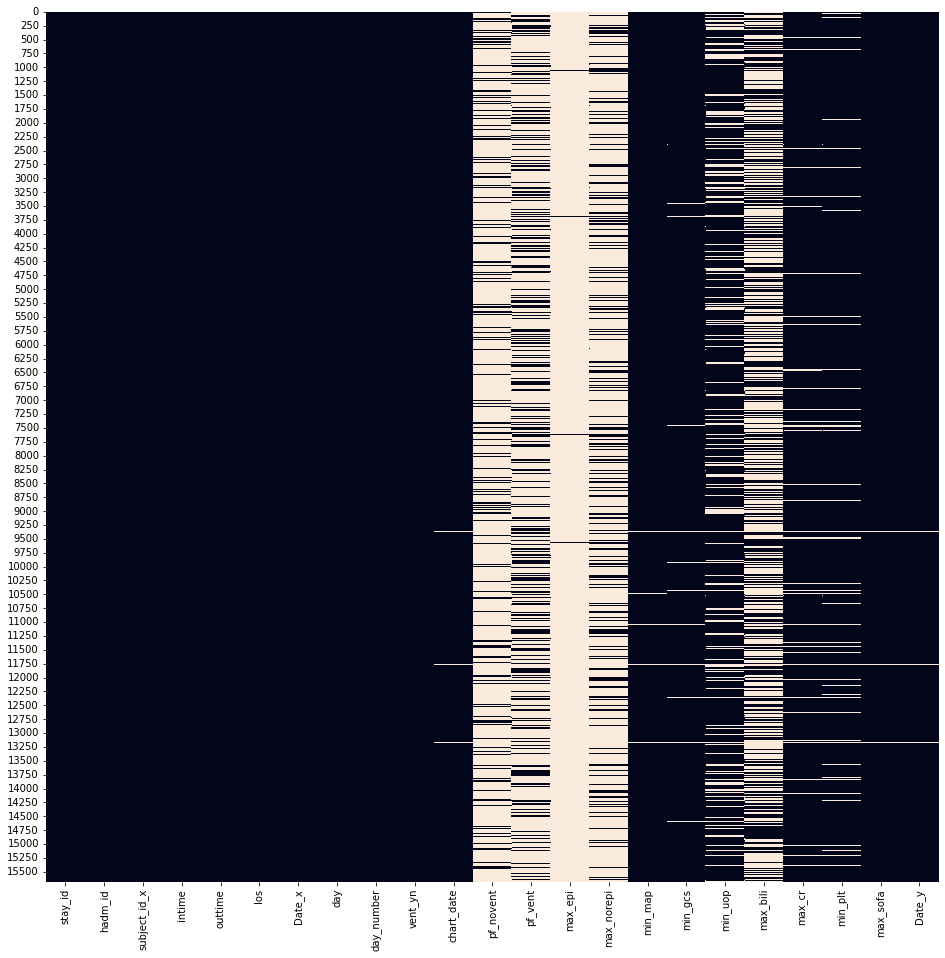

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    pt5.isna(),
    cbar=False,
    yticklabels=250,
)

In [ ]:
pt5.to_csv("MIMIC/micu_vent_sofa3-25-22.csv")

In [ ]:
# merge pf vent columns
# drop max_epi column as rarely used
# fill in 0 for NA max norepi as if not documented was likely 0
#check for outliers 

# Dialysis

In [ ]:
%%bigquery dialysis_by_day

SELECT stay_id, CAST(charttime AS DATE) AS  chart_date, MAX(dialysis_active) AS Max
 FROM `physionet-data.mimic_derived.rrt` 
GROUP BY stay_id, CAST(charttime AS DATE)


In [ ]:
dialysis_by_day[dialysis_by_day.stay_id==34230893]

stay_id  chart_date  Max
1      34230893  2194-07-23    0
3      34230893  2194-07-24    0
9642   34230893  2194-07-25    0
10683  34230893  2194-07-22    1

In [ ]:
dialysis_by_day=dialysis_by_day.rename(columns={'chart_date':'day', 'Max':'dialysis_yn'})

In [ ]:
dialysis_by_day['day'] = pd.to_datetime(dialysis_by_day.day)

In [ ]:
pt6 = pd.merge(pt5, dialysis_by_day, how='left', on=['stay_id', 'day'])

In [ ]:
pt6.to_csv("MIMIC/micu_vent_sofa_dialysis3-25-22.csv")

In [ ]:
pt6

stay_id   hadm_id  subject_id_x               intime  \
0      30061692  22637281      10645926  2192-03-18 04:51:00   
1      30061692  22637281      10645926  2192-03-18 04:51:00   
2      30061692  22637281      10645926  2192-03-18 04:51:00   
3      30061692  22637281      10645926  2192-03-18 04:51:00   
4      30117582  25682203      17768973  2192-07-02 02:48:54   
...         ...       ...           ...                  ...   
15672  39918058  23914765      15689523  2159-06-25 16:26:17   
15673  39918058  23914765      15689523  2159-06-25 16:26:17   
15674  39918058  23914765      15689523  2159-06-25 16:26:17   
15675  39918058  23914765      15689523  2159-06-25 16:26:17   
15676  39918058  23914765      15689523  2159-06-25 16:26:17   

                   outtime        los              Date_x        day  \
0      2192-03-21 13:55:12   3.377917 2192-03-18 04:51:00 2192-03-18   
1      2192-03-21 13:55:12   3.377917 2192-03-19 04:51:00 2192-03-19   
2      2192-03-21 13:55:12   3.377917 2192-03-20 04:51:00 2192-03-20   
3      2192-03-21 13:55:12   3.377917 2192-03-21 04:51:00 2192-03-21   
4      2192-07-14 12:33:50  12.406204 2192-07-02 02:48:54 2192-07-02   
...                    ...        ...                 ...        ...   
15672  2159-07-24 20:49:26  29.182743 2159-07-20 16:26:17 2159-07-20   
15673  2159-07-24 20:49:26  29.182743 2159-07-21 16:26:17 2159-07-21   
15674  2159-07-24 20:49:26  29.182743 2159-07-22 16:26:17 2159-07-22   
15675  2159-07-24 20:49:26  29.182743 2159-07-23 16:26:17 2159-07-23   
15676  2159-07-24 20:49:26  29.182743 2159-07-24 16:26:17 2159-07-24   

       day_number  vent_yn  ... max_norepi  min_map  min_gcs      min_uop  \
0               1        1  ...   0.200002     55.0     15.0          NaN   
1               2        1  ...   0.029934     61.0     15.0  1606.779661   
2               3        0  ...        NaN     64.0     10.0  1630.000000   
3               4        0  ...        NaN     74.0     13.0  3396.923077   
4               1        1  ...   0.251120     57.0     15.0          NaN   
...           ...      ...  ...        ...      ...      ...          ...   
15672          26        0  ...   0.077368     54.0     15.0          NaN   
15673          27        0  ...   0.069556     56.0     15.0          NaN   
15674          28        0  ...        NaN     63.0     12.0          NaN   
15675          29        0  ...        NaN     29.0     15.0          NaN   
15676          30        0  ...        NaN     59.0     15.0          NaN   

       max_bili  max_cr  min_plt  max_sofa     Date_y  dialysis_yn  
0           0.2     2.3    284.0      10.0 2192-03-18          NaN  
1           0.5     1.3    192.0      10.0 2192-03-19          NaN  
2           NaN     1.0    121.0       7.0 2192-03-20          NaN  
3           NaN     0.9    134.0       4.0 2192-03-21          NaN  
4           1.0     6.1    150.0      11.0 2192-07-02          1.0  
...         ...     ...      ...       ...        ...          ...  
15672       NaN     2.7     80.0       8.0 2159-07-20          0.0  
15673       NaN     3.1     83.0       7.0 2159-07-21          1.0  
15674       NaN     2.6     74.0       9.0 2159-07-22          NaN  
15675       NaN     2.9     81.0       7.0 2159-07-23          NaN  
15676       NaN     3.3     84.0       5.0 2159-07-24          1.0  

[15677 rows x 24 columns]

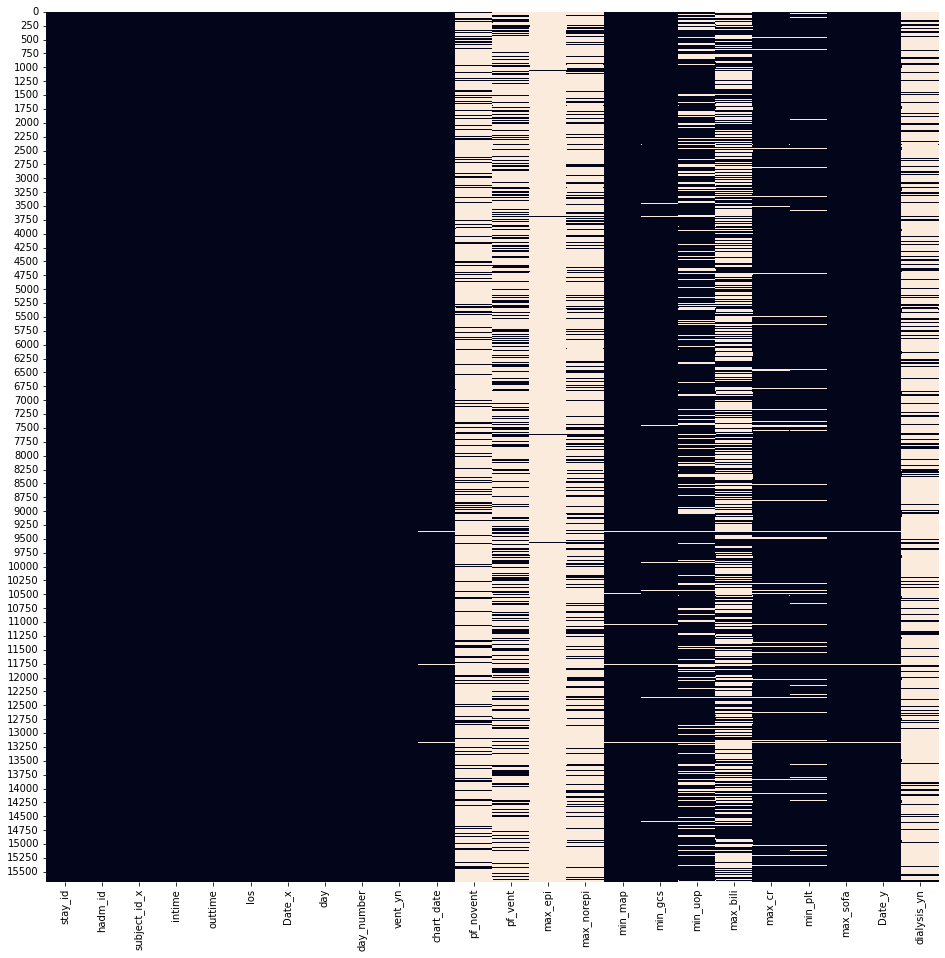

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    pt6.isna(),
    cbar=False,
    yticklabels=250,
)
#ughh missing a bunch of yes/no dialysis, can we impute no dialysis on days with missing information? 
#is the dialysis derived table only taking those with dialysis present? 
# this looks like it's the case, so we can probably impute 0 for all those without dialysis active that day.


# Ventilator parameters

There are several different types, but CMV appears to be equivalent to Puritan Bennett ACVC and is the vast majority of the modes besides PSV/CPAP and standby modes - let's take settings where modes are CMV

In [8]:
pt6 = pd.read_csv("MIMIC/micu_vent_sofa_dialysis3-25-22.csv")

In [10]:
pt6.head()

Unnamed: 0   stay_id   hadm_id  subject_id_x               intime  \
0           0  30061692  22637281      10645926  2192-03-18 04:51:00   
1           1  30061692  22637281      10645926  2192-03-18 04:51:00   
2           2  30061692  22637281      10645926  2192-03-18 04:51:00   
3           3  30061692  22637281      10645926  2192-03-18 04:51:00   
4           4  30117582  25682203      17768973  2192-07-02 02:48:54   

               outtime        los               Date_x         day  \
0  2192-03-21 13:55:12   3.377917  2192-03-18 04:51:00  2192-03-18   
1  2192-03-21 13:55:12   3.377917  2192-03-19 04:51:00  2192-03-19   
2  2192-03-21 13:55:12   3.377917  2192-03-20 04:51:00  2192-03-20   
3  2192-03-21 13:55:12   3.377917  2192-03-21 04:51:00  2192-03-21   
4  2192-07-14 12:33:50  12.406204  2192-07-02 02:48:54  2192-07-02   

   day_number  ...  max_norepi min_map  min_gcs      min_uop  max_bili  \
0           1  ...    0.200002    55.0     15.0          NaN       0.2   
1           2  ...    0.029934    61.0     15.0  1606.779661       0.5   
2           3  ...         NaN    64.0     10.0  1630.000000       NaN   
3           4  ...         NaN    74.0     13.0  3396.923077       NaN   
4           1  ...    0.251120    57.0     15.0          NaN       1.0   

   max_cr  min_plt  max_sofa      Date_y  dialysis_yn  
0     2.3    284.0      10.0  2192-03-18          NaN  
1     1.3    192.0      10.0  2192-03-19          NaN  
2     1.0    121.0       7.0  2192-03-20          NaN  
3     0.9    134.0       4.0  2192-03-21          NaN  
4     6.1    150.0      11.0  2192-07-02          1.0  

[5 rows x 25 columns]

In [11]:
%%bigquery vent_by_day

select stay_id, CAST(charttime AS DATE) AS  chart_date, avg(fio2) as avg_fio2, avg(peep) as avg_peep, avg(respiratory_rate_total) as avg_rr, avg(tidal_volume_observed) as avg_tv, avg(minute_volume) as avg_mv, avg(plateau_pressure) as avg_platpress
from `physionet-data.mimic_derived.ventilator_setting`
where ventilator_mode like '%CMV%'
GROUP BY stay_id, CAST(charttime AS DATE)

In [12]:
vent_by_day

stay_id  chart_date   avg_fio2   avg_peep     avg_rr      avg_tv  \
0      38943957  2163-10-12  24.000000   5.000000  18.000000  450.000000   
1      36917388  2163-02-25  26.666667   5.000000  17.000000  450.000000   
2      34199707  2148-07-02  42.500000   5.000000  12.875000  473.500000   
3      38255279  2120-03-01  84.000000  14.400000  25.200000  479.000000   
4      32086796  2157-08-10  51.666667  13.000000  24.000000  494.500000   
...         ...         ...        ...        ...        ...         ...   
56659  35632600  2179-06-03  66.666667   5.000000  18.666667  454.333333   
56660  30355176  2177-06-19  66.666667   5.000000  18.333333  470.000000   
56661  36477794  2169-09-26  66.666667   5.000000  21.333333  483.000000   
56662  38943946  2131-02-06  66.666667   5.000000  17.666667  428.666667   
56663  34120793  2179-02-25  66.666667   8.333333  18.000000  472.333333   

          avg_mv  avg_platpress  
0            NaN            NaN  
1       7.650000            NaN  
2       7.037500      13.666667  
3      10.940000      28.000000  
4      13.225000      20.833333  
...          ...            ...  
56659   9.966667      19.000000  
56660   9.850000      19.000000  
56661   9.600000      20.333333  
56662   7.300000      18.333333  
56663   8.200000      21.000000  

[56664 rows x 8 columns]

In [17]:
vent_by_day[vent_by_day.stay_id==32086796]

stay_id  chart_date   avg_fio2   avg_peep  avg_rr      avg_tv  \
4      32086796  2157-08-10  51.666667  13.000000  24.000  494.500000   
6      32086796  2157-08-08  56.000000  14.200000  22.000  469.000000   
10     32086796  2157-08-13  47.500000  14.500000  27.500  513.000000   
7830   32086796  2157-08-15  51.428571  14.485714  28.000  501.000000   
11766  32086796  2157-08-19  40.000000  10.450000  32.250  481.750000   
20825  32086796  2157-08-22  40.000000   8.200000  16.000  315.000000   
25979  32086796  2157-08-18  40.000000  16.000000  28.000  458.000000   
26425  32086796  2157-08-12  50.000000  16.000000  28.625  534.333333   
26426  32086796  2157-08-09  50.000000  16.333333  25.800  466.000000   
26427  32086796  2157-08-11  50.000000  15.400000  26.500  615.000000   
29353  32086796  2157-08-14  50.000000  13.666667  28.000  502.666667   
34290  32086796  2157-08-16  50.000000  15.866667  28.000  495.833333   
34428  32086796  2157-08-17  50.000000  15.766667  28.000  482.000000   
56637  32086796  2157-08-06  66.666667   5.000000  19.000  564.000000   

          avg_mv  avg_platpress  
4      13.225000      20.833333  
6      11.360000      23.333333  
10     13.925000      24.000000  
7830   13.814286      25.285714  
11766  12.650000      18.000000  
20825   8.000000      15.000000  
25979  12.500000      23.000000  
26425  13.150000      24.666667  
26426  11.966667      23.500000  
26427  12.450000      23.400000  
29353  13.833333      24.500000  
34290  13.683333      25.166667  
34428  13.283333      24.333333  
56637  10.833333      17.000000

In [18]:
vent_by_day.dtypes

stay_id            int64
chart_date        object
avg_fio2         float64
avg_peep         float64
avg_rr           float64
avg_tv           float64
avg_mv           float64
avg_platpress    float64
dtype: object

In [19]:
vent_by_day['day'] = pd.to_datetime(vent_by_day.chart_date)

In [20]:
vent_by_day.dtypes

stay_id                   int64
chart_date               object
avg_fio2                float64
avg_peep                float64
avg_rr                  float64
avg_tv                  float64
avg_mv                  float64
avg_platpress           float64
day              datetime64[ns]
dtype: object

In [21]:
pt6.dtypes

Unnamed: 0        int64
stay_id           int64
hadm_id           int64
subject_id_x      int64
intime           object
outtime          object
los             float64
Date_x           object
day              object
day_number        int64
vent_yn           int64
chart_date       object
pf_novent       float64
pf_vent         float64
max_epi         float64
max_norepi      float64
min_map         float64
min_gcs         float64
min_uop         float64
max_bili        float64
max_cr          float64
min_plt         float64
max_sofa        float64
Date_y           object
dialysis_yn     float64
dtype: object

In [22]:
pt6=pt6.drop(columns=['Date_y', 'Date_x'])

In [23]:
pt6['day'] = pd.to_datetime(pt6.day)

In [24]:
pt6.dtypes

Unnamed: 0               int64
stay_id                  int64
hadm_id                  int64
subject_id_x             int64
intime                  object
outtime                 object
los                    float64
day             datetime64[ns]
day_number               int64
vent_yn                  int64
chart_date              object
pf_novent              float64
pf_vent                float64
max_epi                float64
max_norepi             float64
min_map                float64
min_gcs                float64
min_uop                float64
max_bili               float64
max_cr                 float64
min_plt                float64
max_sofa               float64
dialysis_yn            float64
dtype: object

In [25]:
pt7 = pd.merge(pt6, vent_by_day, how='left', on=['stay_id', 'day'])

In [28]:
pt7.sample(n=10)

Unnamed: 0   stay_id   hadm_id  subject_id_x               intime  \
11395       11395  38099047  29886432      11327015  2134-11-06 20:42:00   
11481       11481  39008675  25273366      12167722  2153-09-04 09:28:53   
15468       15468  37119050  28546355      15360211  2177-06-16 17:57:46   
10137       10137  37054128  26834703      12838416  2124-09-26 10:51:17   
9169         9169  38513835  20063453      19368849  2196-10-28 17:13:32   
8042         8042  30261457  26248295      15152579  2196-11-15 23:45:24   
5369         5369  35499050  26380208      18253389  2188-09-01 01:39:14   
1046         1046  38444495  23701942      13382552  2174-11-04 18:38:00   
12568       12568  32950965  29615907      18361380  2174-04-21 18:34:40   
8843         8843  35967845  22689342      11343907  2178-07-08 13:54:57   

                   outtime        los        day  day_number  vent_yn  ...  \
11395  2134-11-16 15:18:50   9.775579 2134-11-08           3        0  ...   
11481  2153-10-05 04:48:18  30.805150 2153-09-21          18        0  ...   
15468  2177-06-29 18:21:15  13.016308 2177-06-29          14        0  ...   
10137  2124-10-10 21:56:18  14.461817 2124-10-07          12        0  ...   
9169   2196-11-24 02:15:13  26.376169 2196-11-20          24        0  ...   
8042   2196-12-02 20:26:41  16.862002 2196-11-26          12        0  ...   
5369   2188-10-06 20:57:41  35.804479 2188-10-01          31        1  ...   
1046   2174-11-13 20:26:04   9.075046 2174-11-09           6        1  ...   
12568  2174-05-22 15:55:17  30.889317 2174-05-15          25        0  ...   
8843   2178-07-15 14:10:22   7.010706 2178-07-12           5        0  ...   

      min_plt  max_sofa  dialysis_yn  chart_date_y   avg_fio2   avg_peep  \
11395   133.0       3.0          NaN           NaN        NaN        NaN   
11481   185.0      12.0          1.0           NaN        NaN        NaN   
15468   358.0       5.0          NaN           NaN        NaN        NaN   
10137   148.0       6.0          NaN    2124-10-07  68.333333  12.666667   
9169     24.0       5.0          NaN           NaN        NaN        NaN   
8042    243.0       4.0          NaN           NaN        NaN        NaN   
5369     34.0       9.0          0.0           NaN        NaN        NaN   
1046    334.0       3.0          NaN           NaN        NaN        NaN   
12568   293.0       4.0          NaN    2174-05-15  40.000000   5.033333   
8843    133.0      11.0          1.0           NaN        NaN        NaN   

          avg_rr      avg_tv     avg_mv  avg_platpress  
11395        NaN         NaN        NaN            NaN  
11481        NaN         NaN        NaN            NaN  
15468        NaN         NaN        NaN            NaN  
10137  31.833333  485.000000  13.533333          26.75  
9169         NaN         NaN        NaN            NaN  
8042         NaN         NaN        NaN            NaN  
5369         NaN         NaN        NaN            NaN  
1046         NaN         NaN        NaN            NaN  
12568  16.833333  453.333333   7.400000          16.00  
8843         NaN         NaN        NaN            NaN  

[10 rows x 30 columns]

In [ ]:
# discordance - some of these may make sense such as vent =1 but parameters =NA if someone was getting pressure support
# but I'm also getting options when vent=0 but parameters have values ?

# Suggestions from Thomas:
#try with minimal necessary columns 
#counting up mismatched and how mismatched 
#start/end time is off? 

In [80]:
pt7.head()

Unnamed: 0   stay_id   hadm_id  subject_id_x               intime  \
0           0  30061692  22637281      10645926  2192-03-18 04:51:00   
1           1  30061692  22637281      10645926  2192-03-18 04:51:00   
2           2  30061692  22637281      10645926  2192-03-18 04:51:00   
3           3  30061692  22637281      10645926  2192-03-18 04:51:00   
4           4  30117582  25682203      17768973  2192-07-02 02:48:54   

               outtime        los        day  day_number  vent_yn  ...  \
0  2192-03-21 13:55:12   3.377917 2192-03-18           1        1  ...   
1  2192-03-21 13:55:12   3.377917 2192-03-19           2        1  ...   
2  2192-03-21 13:55:12   3.377917 2192-03-20           3        0  ...   
3  2192-03-21 13:55:12   3.377917 2192-03-21           4        0  ...   
4  2192-07-14 12:33:50  12.406204 2192-07-02           1        1  ...   

  min_plt  max_sofa  dialysis_yn  chart_date_y  avg_fio2  avg_peep  avg_rr  \
0   284.0      10.0          NaN    2192-03-18      54.0      9.54    17.0   
1   192.0      10.0          NaN    2192-03-19      50.0     10.30    20.0   
2   121.0       7.0          NaN           NaN       NaN       NaN     NaN   
3   134.0       4.0          NaN           NaN       NaN       NaN     NaN   
4   150.0      11.0          1.0           NaN       NaN       NaN     NaN   

   avg_tv  avg_mv  avg_platpress  
0   446.0    9.72           24.0  
1   480.0    9.30           23.0  
2     NaN     NaN            NaN  
3     NaN     NaN            NaN  
4     NaN     NaN            NaN  

[5 rows x 30 columns]

In [35]:
vent_duration #derived from pt3 above before start/endtime were removed 

stay_id   hadm_id           starttime             endtime  \
0      30061692  22637281 2192-03-18 05:00:00 2192-03-19 10:00:00   
1      30061692  22637281 2192-03-18 05:00:00 2192-03-19 10:00:00   
2      30061692  22637281 2192-03-18 05:00:00 2192-03-19 10:00:00   
3      30061692  22637281 2192-03-18 05:00:00 2192-03-19 10:00:00   
4      30117582  25682203 2192-07-02 03:46:00 2192-07-09 07:00:00   
...         ...       ...                 ...                 ...   
15672  39918058  23914765 2159-07-04 20:00:00 2159-07-06 12:00:00   
15673  39918058  23914765 2159-07-04 20:00:00 2159-07-06 12:00:00   
15674  39918058  23914765 2159-07-04 20:00:00 2159-07-06 12:00:00   
15675  39918058  23914765 2159-07-04 20:00:00 2159-07-06 12:00:00   
15676  39918058  23914765 2159-07-04 20:00:00 2159-07-06 12:00:00   

                    intime              outtime        los         day  \
0      2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917  2192-03-18   
1      2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917  2192-03-19   
2      2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917  2192-03-20   
3      2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917  2192-03-21   
4      2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204  2192-07-02   
...                    ...                  ...        ...         ...   
15672  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743  2159-07-20   
15673  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743  2159-07-21   
15674  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743  2159-07-22   
15675  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743  2159-07-23   
15676  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743  2159-07-24   

       day_number  vent_yn  
0               1        1  
1               2        1  
2               3        0  
3               4        0  
4               1        1  
...           ...      ...  
15672          26        0  
15673          27        0  
15674          28        0  
15675          29        0  
15676          30        0  

[15677 rows x 10 columns]

In [36]:
vent_by_day[vent_by_day.stay_id==32950965]

stay_id  chart_date   avg_fio2   avg_peep     avg_rr      avg_tv  \
4483   32950965  2174-05-07  44.285714   6.000000  14.857143  425.000000   
4934   32950965  2174-04-23  42.000000   5.000000  14.400000  384.800000   
12139  32950965  2174-05-01  40.000000   5.000000  12.000000  416.333333   
12601  32950965  2174-05-04  40.000000   5.000000  13.000000  370.833333   
13033  32950965  2174-05-14  40.000000   5.066667  16.666667  499.000000   
14572  32950965  2174-05-18  40.000000   5.000000  19.200000  411.333333   
14716  32950965  2174-05-19  40.000000   5.000000  16.250000  409.000000   
15830  32950965  2174-05-16  40.000000   5.000000  18.500000  373.571429   
17513  32950965  2174-04-29  40.000000  10.000000  14.250000  420.500000   
17627  32950965  2174-04-28  40.000000  10.000000  13.714286  389.285714   
18036  32950965  2174-05-06  40.000000   5.000000  12.000000  406.666667   
18084  32950965  2174-04-24  40.000000   5.166667  18.833333  396.833333   
18125  32950965  2174-04-25  40.000000   5.000000  15.166667  386.666667   
18565  32950965  2174-05-05  40.000000   5.000000  13.285714  415.285714   
18800  32950965  2174-05-03  40.000000   5.000000  15.000000  430.571429   
19701  32950965  2174-05-02  40.000000   5.000000  13.428571  432.428571   
20749  32950965  2174-04-27  40.000000   8.000000  12.400000  410.400000   
21427  32950965  2174-04-30  40.000000  10.000000  13.666667  414.333333   
21473  32950965  2174-05-17  40.000000   5.000000  16.000000  401.500000   
22583  32950965  2174-05-11  40.000000   5.000000  20.000000  421.333333   
24683  32950965  2174-05-15  40.000000   5.033333  16.833333  453.333333   
30907  32950965  2174-05-08  50.000000   5.000000  15.800000  401.600000   
31907  32950965  2174-04-22  50.000000   5.000000  15.000000  370.333333   
32452  32950965  2174-05-09  50.000000   5.000000  13.500000  438.200000   
54295  32950965  2174-04-26  46.666667   8.333333  17.500000  422.333333   
55229  32950965  2174-05-10  43.333333   5.000000  15.500000  432.000000   

         avg_mv  avg_platpress        day  
4483   6.185714      18.500000 2174-05-07  
4934   5.736000      21.000000 2174-04-23  
12139  5.066667      16.000000 2174-05-01  
12601  6.000000      19.000000 2174-05-04  
13033  7.200000      13.666667 2174-05-14  
14572  8.533333      17.000000 2174-05-18  
14716  6.375000      16.000000 2174-05-19  
15830  6.014286      18.000000 2174-05-16  
17513  5.875000      21.333333 2174-04-29  
17627  5.471429      21.600000 2174-04-28  
18036  5.333333      18.750000 2174-05-06  
18084  7.108333      19.750000 2174-04-24  
18125  5.593333      18.166667 2174-04-25  
18565  5.685714      17.571429 2174-05-05  
18800  6.557143      17.000000 2174-05-03  
19701  6.314286      18.000000 2174-05-02  
20749  5.060000      19.750000 2174-04-27  
21427  5.466667      22.000000 2174-04-30  
21473  7.416667      16.333333 2174-05-17  
22583  6.900000      17.333333 2174-05-11  
24683  7.400000      16.000000 2174-05-15  
30907  5.840000      15.250000 2174-05-08  
31907  5.933333      21.333333 2174-04-22  
32452  6.420000      17.666667 2174-05-09  
54295  8.466667      21.000000 2174-04-26  
55229  5.250000      17.200000 2174-05-10

In [37]:
vent_duration[vent_duration.stay_id==32950965] #maybe there are multiple intubations in each ICU stay that is not getting captured in this table 

stay_id   hadm_id           starttime             endtime  \
12544  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12545  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12546  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12547  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12548  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12549  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12550  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12551  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12552  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12553  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12554  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12555  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12556  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12557  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12558  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12559  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12560  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12561  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12562  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12563  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12564  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12565  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12566  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12567  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12568  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12569  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12570  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12571  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12572  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12573  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   
12574  32950965  29615907 2174-05-06 13:00:00 2174-05-11 08:00:00   

                    intime              outtime        los         day  \
12544  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-21   
12545  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-22   
12546  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-23   
12547  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-24   
12548  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-25   
12549  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-26   
12550  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-27   
12551  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-28   
12552  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-29   
12553  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-04-30   
12554  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-01   
12555  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-02   
12556  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-03   
12557  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-04   
12558  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-05   
12559  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-06   
12560  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-07   
12561  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-08   
12562  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-09   
12563  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-10   
12564  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-11   
12565  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-12   
12566  2174-04-21 18:34:40  2174-05-22 15:55:17  30.889317  2174-05-13   
12567  2174-04-21 18:34

In [38]:
pt7[pt7.stay_id==32950965]

Unnamed: 0   stay_id   hadm_id  subject_id_x               intime  \
12544       12544  32950965  29615907      18361380  2174-04-21 18:34:40   
12545       12545  32950965  29615907      18361380  2174-04-21 18:34:40   
12546       12546  32950965  29615907      18361380  2174-04-21 18:34:40   
12547       12547  32950965  29615907      18361380  2174-04-21 18:34:40   
12548       12548  32950965  29615907      18361380  2174-04-21 18:34:40   
12549       12549  32950965  29615907      18361380  2174-04-21 18:34:40   
12550       12550  32950965  29615907      18361380  2174-04-21 18:34:40   
12551       12551  32950965  29615907      18361380  2174-04-21 18:34:40   
12552       12552  32950965  29615907      18361380  2174-04-21 18:34:40   
12553       12553  32950965  29615907      18361380  2174-04-21 18:34:40   
12554       12554  32950965  29615907      18361380  2174-04-21 18:34:40   
12555       12555  32950965  29615907      18361380  2174-04-21 18:34:40   
12556       12556  32950965  29615907      18361380  2174-04-21 18:34:40   
12557       12557  32950965  29615907      18361380  2174-04-21 18:34:40   
12558       12558  32950965  29615907      18361380  2174-04-21 18:34:40   
12559       12559  32950965  29615907      18361380  2174-04-21 18:34:40   
12560       12560  32950965  29615907      18361380  2174-04-21 18:34:40   
12561       12561  32950965  29615907      18361380  2174-04-21 18:34:40   
12562       12562  32950965  29615907      18361380  2174-04-21 18:34:40   
12563       12563  32950965  29615907      18361380  2174-04-21 18:34:40   
12564       12564  32950965  29615907      18361380  2174-04-21 18:34:40   
12565       12565  32950965  29615907      18361380  2174-04-21 18:34:40   
12566       12566  32950965  29615907      18361380  2174-04-21 18:34:40   
12567       12567  32950965  29615907      18361380  2174-04-21 18:34:40   
12568       12568  32950965  29615907      18361380  2174-04-21 18:34:40   
12569       12569  32950965  29615907      18361380  2174-04-21 18:34:40   
12570       12570  32950965  29615907      18361380  2174-04-21 18:34:40   
12571       12571  32950965  29615907      18361380  2174-04-21 18:34:40   
12572       12572  32950965  29615907      18361380  2174-04-21 18:34:40   
12573       12573  32950965  29615907      18361380  2174-04-21 18:34:40   
12574       12574  32950965  29615907      18361380  2174-04-21 18:34:40   

                   outtime        los        day  day_number  vent_yn  ...  \
12544  2174-05-22 15:55:17  30.889317 2174-04-21           1        0  ...   
12545  2174-05-22 15:55:17  30.889317 2174-04-22           2        0  ...   
12546  2174-05-22 15:55:17  30.889317 2174-04-23           3        0  ...   
12547  2174-05-22 15:55:17  30.889317 2174-04-24           4        0  ...   
12548  2174-05-22 15:55:17  30.889317 2174-04-25           5        0  ...   
12549  2174-05-22 15:55:17  30.889317 2174-04-26           6        0  ...   
12550  2174-05-22 15:55:17  30.889317 2174-04-27           7        0  ...   
12551  2174-05-22 15:55:17  30.889317 2174-04-28           8        0  ...   
12552  2174-05-22 15:55:17  30.889317 2174-04-29           9        0  ...   
12553  2174-05-22 15:55:17  30.889317 2174-04-30          10        0  ...   
12554  2174-05-22 15:55:17  30.889317 2174-05-01          11        0  ...   
12555  2174-05-22 15:55:17  30.889317 2174-05-02          12        0  ...   
12556  2174-05-22 15:55:17  30.889317 2174-05-03          13        0  ...   
12557  2174-05-22 15:55:17  30.889317 2174-05-04          14        0  ...   
12558  2174-05-22 15:55:17  30.889317 2174-05-05          15        0  ...   
12559  2174-05-22 15:55:17  30.889317 2174-05-06          16        1  ...   
12560  2174-05-22 15:55:17  30.889317 2174-05-07          17        1  ...   
12561  2174-05-22 15:55:17  30.889317 2174-05-08          18        1  ...   
12562  2174-05-22 15:55:17  30.889317 2174-05-09          19        1  ...   
12563  2174-05

In [45]:
#let's go back and examine this in bq for stayid 32950965

%%bigquery example_stay

SELECT *
FROM `physionet-data.mimic_derived.ventilation` 
where stay_id=32950965


In [46]:
example_stay
#yup, there are multiple start/endtimes for ventilation that I probably threw out when counting initially 
#will need to pull these again to properly populate the vent_yn column 
#or can we just use the full vent information to populate this column? but then only full control vent settings 
#also, does any of this matter? 

stay_id           starttime             endtime  ventilation_status
0  32950965 2174-05-06 13:00:00 2174-05-11 08:00:00        InvasiveVent
1  32950965 2174-04-22 18:00:00 2174-04-30 08:00:00        InvasiveVent
2  32950965 2174-05-01 10:00:00 2174-05-06 12:00:00        InvasiveVent
3  32950965 2174-05-14 10:30:00 2174-05-19 12:21:00        InvasiveVent
4  32950965 2174-04-21 21:19:00 2174-04-22 04:00:00  SupplementalOxygen

In [ ]:
#see below section troubleshoot for examining of this section - pulling the multiple examples does improve the match but it's still not perfect

# other vitals

In [39]:
%%bigquery vitals_by_day

SELECT stay_id, CAST(charttime AS DATE) AS chart_date, 
    min(heart_rate) AS min_hr,
    max(heart_rate) as max_hr,
    min(resp_rate) as min_rr,
    max(resp_rate) as max_rr,
    min(temperature) as min_temp,
    max(temperature) as max_temp, 
    min(spo2) as min_spo2,
 FROM `physionet-data.mimic_derived.vitalsign` 
GROUP BY stay_id, CAST(charttime AS DATE)


In [40]:
vitals_by_day

stay_id  chart_date  min_hr  max_hr  min_rr  max_rr  min_temp  \
0       38150079  2180-10-09    46.0    73.0    12.0    47.0     35.33   
1       36561068  2186-05-16   104.0   138.0    24.0    42.0     37.11   
2       34494950  2177-08-27   114.0   147.0    30.0    43.0     37.22   
3       33460567  2144-10-27    38.0   170.0     8.0    48.0     36.67   
4       30063714  2133-01-12   110.0   133.0    17.0    40.0     37.06   
...          ...         ...     ...     ...     ...     ...       ...   
332146  34916121  2120-08-03    99.0    99.0    19.0    19.0       NaN   
332147  38356745  2170-06-29    99.0    99.0    19.0    19.0       NaN   
332148  31774068  2132-10-23    99.0    99.0    20.0    20.0       NaN   
332149  37221378  2144-11-08    99.0    99.0    20.0    20.0       NaN   
332150  31410635  2133-05-08    99.0    99.0    23.0    23.0       NaN   

        max_temp  min_spo2  
0          36.78      99.0  
1          37.67      88.0  
2          38.33      93.0  
3          37.06      76.0  
4          38.78      96.0  
...          ...       ...  
332146       NaN       NaN  
332147       NaN      82.0  
332148       NaN      99.0  
332149       NaN      93.0  
332150       NaN      93.0  

[332151 rows x 9 columns]

In [41]:
vitals_by_day['day'] = pd.to_datetime(vitals_by_day.chart_date)

In [42]:
pt8 = pd.merge(pt7, vitals_by_day, how='left', on=['stay_id', 'day'])

In [43]:
pt8

Unnamed: 0   stay_id   hadm_id  subject_id_x               intime  \
0               0  30061692  22637281      10645926  2192-03-18 04:51:00   
1               1  30061692  22637281      10645926  2192-03-18 04:51:00   
2               2  30061692  22637281      10645926  2192-03-18 04:51:00   
3               3  30061692  22637281      10645926  2192-03-18 04:51:00   
4               4  30117582  25682203      17768973  2192-07-02 02:48:54   
...           ...       ...       ...           ...                  ...   
15672       15672  39918058  23914765      15689523  2159-06-25 16:26:17   
15673       15673  39918058  23914765      15689523  2159-06-25 16:26:17   
15674       15674  39918058  23914765      15689523  2159-06-25 16:26:17   
15675       15675  39918058  23914765      15689523  2159-06-25 16:26:17   
15676       15676  39918058  23914765      15689523  2159-06-25 16:26:17   

                   outtime        los        day  day_number  vent_yn  ...  \
0      2192-03-21 13:55:12   3.377917 2192-03-18           1        1  ...   
1      2192-03-21 13:55:12   3.377917 2192-03-19           2        1  ...   
2      2192-03-21 13:55:12   3.377917 2192-03-20           3        0  ...   
3      2192-03-21 13:55:12   3.377917 2192-03-21           4        0  ...   
4      2192-07-14 12:33:50  12.406204 2192-07-02           1        1  ...   
...                    ...        ...        ...         ...      ...  ...   
15672  2159-07-24 20:49:26  29.182743 2159-07-20          26        0  ...   
15673  2159-07-24 20:49:26  29.182743 2159-07-21          27        0  ...   
15674  2159-07-24 20:49:26  29.182743 2159-07-22          28        0  ...   
15675  2159-07-24 20:49:26  29.182743 2159-07-23          29        0  ...   
15676  2159-07-24 20:49:26  29.182743 2159-07-24          30        0  ...   

      avg_mv  avg_platpress  chart_date  min_hr  max_hr  min_rr  max_rr  \
0       9.72           24.0  2192-03-18    86.0   124.0    19.0    26.0   
1       9.30           23.0  2192-03-19    78.0   104.0    12.0    27.0   
2        NaN            NaN  2192-03-20    59.0    99.0    12.0    30.0   
3        NaN            NaN  2192-03-21    74.0    95.0    14.0    33.0   
4        NaN            NaN  2192-07-02    70.0    95.0    18.0    31.0   
...      ...            ...         ...     ...     ...     ...     ...   
15672    NaN            NaN  2159-07-20    79.0   120.0    11.0    29.0   
15673    NaN            NaN  2159-07-21    88.0   121.0    12.0    29.0   
15674    NaN            NaN  2159-07-22    76.0   107.0    11.0    25.0   
15675    NaN            NaN  2159-07-23    82.0   102.0    14.0    26.0   
15676    NaN            NaN  2159-07-24    83.0   110.0    15.0    32.0   

       min_temp  max_temp  min_spo2  
0         37.30     38.20      82.0  
1         36.72     37.44      95.0  
2         36.28     37.50      94.0  
3         36.22     37.94      92.0  
4         36.56     37.72      89.0  
...         ...       ...       ...  
15672     36.83     37.44      92.0  
15673     36.56     37.17      92.0  
15674     36.56     36.94      93.0  
15675     36.78     37.00      93.0  
15676     36.33     36.50      91.0  

[15677 rows x 38 columns]

# ABGs

In [47]:

#po2 is weird and since we have pf ratios separately, we will only pull ph and pc02

%%bigquery abg_by_day

select hadm_id, CAST(charttime AS DATE) AS  chart_date, avg(ph) as avg_ph, avg(pco2) as avg_pco2, 
from `physionet-data.mimic_derived.bg`
where hadm_id is not null and specimen='ART.'
GROUP BY hadm_id, CAST(charttime AS DATE)

In [57]:
abg_by_day

hadm_id  chart_date    avg_ph   avg_pco2        day
0       27319375  2149-08-10  7.375714  24.857143 2149-08-10
1       25191753  2179-09-28  7.510000  31.428571 2179-09-28
2       23353148  2188-05-03  7.080000  80.000000 2188-05-03
3       26009113  2165-09-29  7.080000  79.000000 2165-09-29
4       20944398  2117-08-11  7.180000  67.000000 2117-08-11
...          ...         ...       ...        ...        ...
140331  20714301  2171-08-17  7.290000  43.500000 2171-08-17
140332  21089417  2114-01-12  7.435000  43.500000 2114-01-12
140333  25479449  2192-07-31  7.375000  43.500000 2192-07-31
140334  20127441  2171-07-28  7.355000  43.500000 2171-07-28
140335  24025534  2166-07-07  7.275000  43.500000 2166-07-07

[140336 rows x 5 columns]

In [49]:
abg_by_day['day'] = pd.to_datetime(abg_by_day.chart_date)

In [58]:
pt9 = pd.merge(pt8, abg_by_day, how='left', on=['hadm_id', 'day'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chart_date_x'} in the result is deprecated and will raise a MergeError in a future version.
  """Entry point for launching an IPython kernel.


In [59]:
pt9.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'chart_date_x', 'pf_novent',
       'pf_vent', 'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop',
       'max_bili', 'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn',
       'chart_date_y', 'avg_fio2', 'avg_peep', 'avg_rr', 'avg_tv', 'avg_mv',
       'avg_platpress', 'chart_date_x', 'min_hr', 'max_hr', 'min_rr', 'max_rr',
       'min_temp', 'max_temp', 'min_spo2', 'chart_date_y', 'avg_ph',
       'avg_pco2'],
      dtype='object')

In [60]:
pt9 = pt9.drop(columns=['chart_date_x', 'chart_date_y'])

In [61]:
pt9

Unnamed: 0   stay_id   hadm_id  subject_id_x               intime  \
0               0  30061692  22637281      10645926  2192-03-18 04:51:00   
1               1  30061692  22637281      10645926  2192-03-18 04:51:00   
2               2  30061692  22637281      10645926  2192-03-18 04:51:00   
3               3  30061692  22637281      10645926  2192-03-18 04:51:00   
4               4  30117582  25682203      17768973  2192-07-02 02:48:54   
...           ...       ...       ...           ...                  ...   
15672       15672  39918058  23914765      15689523  2159-06-25 16:26:17   
15673       15673  39918058  23914765      15689523  2159-06-25 16:26:17   
15674       15674  39918058  23914765      15689523  2159-06-25 16:26:17   
15675       15675  39918058  23914765      15689523  2159-06-25 16:26:17   
15676       15676  39918058  23914765      15689523  2159-06-25 16:26:17   

                   outtime        los        day  day_number  vent_yn  ...  \
0      2192-03-21 13:55:12   3.377917 2192-03-18           1        1  ...   
1      2192-03-21 13:55:12   3.377917 2192-03-19           2        1  ...   
2      2192-03-21 13:55:12   3.377917 2192-03-20           3        0  ...   
3      2192-03-21 13:55:12   3.377917 2192-03-21           4        0  ...   
4      2192-07-14 12:33:50  12.406204 2192-07-02           1        1  ...   
...                    ...        ...        ...         ...      ...  ...   
15672  2159-07-24 20:49:26  29.182743 2159-07-20          26        0  ...   
15673  2159-07-24 20:49:26  29.182743 2159-07-21          27        0  ...   
15674  2159-07-24 20:49:26  29.182743 2159-07-22          28        0  ...   
15675  2159-07-24 20:49:26  29.182743 2159-07-23          29        0  ...   
15676  2159-07-24 20:49:26  29.182743 2159-07-24          30        0  ...   

       avg_platpress  min_hr  max_hr  min_rr  max_rr  min_temp  max_temp  \
0               24.0    86.0   124.0    19.0    26.0     37.30     38.20   
1               23.0    78.0   104.0    12.0    27.0     36.72     37.44   
2                NaN    59.0    99.0    12.0    30.0     36.28     37.50   
3                NaN    74.0    95.0    14.0    33.0     36.22     37.94   
4                NaN    70.0    95.0    18.0    31.0     36.56     37.72   
...              ...     ...     ...     ...     ...       ...       ...   
15672            NaN    79.0   120.0    11.0    29.0     36.83     37.44   
15673            NaN    88.0   121.0    12.0    29.0     36.56     37.17   
15674            NaN    76.0   107.0    11.0    25.0     36.56     36.94   
15675            NaN    82.0   102.0    14.0    26.0     36.78     37.00   
15676            NaN    83.0   110.0    15.0    32.0     36.33     36.50   

       min_spo2    avg_ph   avg_pco2  
0          82.0  7.320000  41.500000  
1          95.0  7.373333  37.666667  
2          94.0       NaN        NaN  
3          92.0       NaN        NaN  
4          89.0  7.272000  47.200000  
...         ...       ...        ...  
15672      92.0       NaN        NaN  
15673      92.0       NaN        NaN  
15674      93.0       NaN        NaN  
15675      93.0       NaN        NaN  
15676      91.0       NaN        NaN  

[15677 rows x 37 columns]

In [63]:
pt9.to_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs3-28-22.csv")

# ECMO

Found ce.itemid=229278 is di.label = 'Sweep (ECMO)' so pulling any documented ECMO sweep in for that day means patient was on ECMO that day 

In [64]:
%%bigquery ecmo_by_day

SELECT stay_id, CAST(charttime AS DATE) AS  chart_date, STRING_AGG(value,' ') as agg_ecmo_sweep
from `physionet-data.mimic_icu.chartevents` ce
where ce.itemid=229278
GROUP BY stay_id, CAST(charttime AS DATE)

In [66]:
ecmo_by_day['ecmo_yn'] = 1

In [67]:
ecmo_by_day

stay_id  chart_date                                     agg_ecmo_sweep  \
0    31225400  2118-01-23  3.0 L 3.0 L 1.0 L 3.0 L 3.0 L 1.0 L 1.0 L 1.0 ...   
1    31225400  2118-01-18  6.0 L 6.0 L 6.0 L 2.0 L 6.0 L 6.0 L 2.0 L 6.0 ...   
2    32784340  2114-10-27  2.0 L 2.0 L 2.0 L 2.0 L 2.0 L 2.0 L 2.0 L 2.0 ...   
3    37643900  2153-11-22  3.5 L 2.0 L 5.0 L 5.0 L 5.0 L 3.5 L 5.0 L 1.0 ...   
4    30024161  2185-08-27  2.5 L 2.5 L 2.5 L 2.5 L 2.5 L 2.5 L 2.5 L 2.5 ...   
..        ...         ...                                                ...   
497  31762339  2162-11-15                      5.0 L 5.0 L 5.0 L 5.0 L 5.0 L   
498  34342533  2153-09-18  4.0 L 2.0 L 2.0 L 2.0 L 2.0 L 3.5 L 2.0 L 2.0 ...   
499  37301146  2146-02-18                                  4.0 L 4.0 L 4.0 L   
500  31929937  2147-09-21                                        3.0 L 3.0 L   
501  31140928  2171-03-13                                  6.0 L 6.0 L 6.0 L   

     ecmo_yn  
0          1  
1          1  
2          1  
3          1  
4          1  
..       ...  
497        1  
498        1  
499        1  
500        1  
501        1  

[502 rows x 4 columns]

In [68]:
ecmo_by_day['day'] = pd.to_datetime(ecmo_by_day.chart_date)

In [69]:
ecmo_by_day = ecmo_by_day.drop(columns=['agg_ecmo_sweep'])

In [70]:
pt10 = pd.merge(pt9, ecmo_by_day, how='left', on=['stay_id', 'day']) 

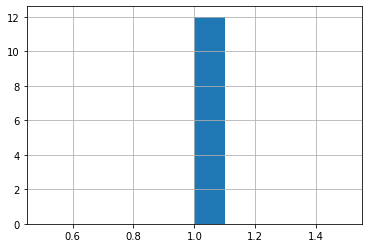

In [75]:
pt10['ecmo_yn'].hist() #12 ecmo patients in this cohort 

In [77]:
pt10.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'pf_novent', 'pf_vent',
       'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop', 'max_bili',
       'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn', 'avg_fio2', 'avg_peep',
       'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress', 'min_hr', 'max_hr',
       'min_rr', 'max_rr', 'min_temp', 'max_temp', 'min_spo2', 'avg_ph',
       'avg_pco2', 'chart_date', 'ecmo_yn'],
      dtype='object')

In [78]:
pt10 = pt10.drop(columns=['Unnamed: 0','chart_date'])

In [79]:
pt10.to_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo3-28-22.csv")

# Troubleshoot/fix vent_yn column




In [6]:
pt10 = pd.read_csv("MIMIC/micu_vent_sofa_dialysis_abg_vs_ecmo3-28-22.csv")

In [8]:
pt10.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'pf_novent', 'pf_vent',
       'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop', 'max_bili',
       'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn', 'avg_fio2', 'avg_peep',
       'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress', 'min_hr', 'max_hr',
       'min_rr', 'max_rr', 'min_temp', 'max_temp', 'min_spo2', 'avg_ph',
       'avg_pco2', 'ecmo_yn'],
      dtype='object')

In [18]:
pt11 = pt10[['stay_id', 'day', 'vent_yn','avg_peep']]

In [23]:
pt11.sample(n=10)

stay_id         day  vent_yn  avg_peep  peep_yn
5560   37329744  2140-11-21        0      6.00        1
14983  31004416  2120-02-16        0       NaN        0
5030   32349593  2188-11-16        1       NaN        0
8957   36974709  2139-02-23        0       NaN        0
8221   31588956  2150-05-22        0       NaN        0
10146  33992578  2124-06-20        0       NaN        0
6323   34621167  2183-07-24        0       NaN        0
8883   36328300  2197-03-12        0       NaN        0
1878   35305163  2179-06-07        0       NaN        0
10289  30992846  2128-08-02        0     10.75        1

In [20]:
pt11['peep_yn'] = 0
pt11.loc[pt11['avg_peep']>0, 'peep_yn']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
pt11.loc[pt11['avg_peep']>0, 'peep_yn']=1

#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [24]:
from sklearn.metrics import confusion_matrix

In [26]:
#confusion_matrix(y_true, y_pred)
confusion_matrix(pt11['peep_yn'], pt11['vent_yn'])

array([[8582, 1584],
       [3331, 2180]])

In [29]:
%%bigquery ventyn_by_day

select *
from `physionet-data.mimic_derived.ventilation` 
where ventilation_status like 'InvasiveVent'

In [30]:
ventyn_by_day

stay_id           starttime             endtime ventilation_status
0      31326208 2135-06-20 23:18:00 2135-06-22 01:00:00       InvasiveVent
1      31195904 2152-08-28 13:00:00 2152-08-29 09:00:00       InvasiveVent
2      35587584 2150-09-27 20:19:00 2150-09-29 09:52:00       InvasiveVent
3      36179968 2111-05-27 14:07:00 2111-05-27 21:44:00       InvasiveVent
4      35918080 2188-11-20 12:00:00 2188-11-21 00:00:00       InvasiveVent
...         ...                 ...                 ...                ...
35167  32697087 2185-12-06 02:00:00 2185-12-10 05:00:00       InvasiveVent
35168  33680639 2177-06-20 18:00:00 2177-06-21 02:00:00       InvasiveVent
35169  34077183 2153-01-01 06:28:00 2153-01-02 07:00:00       InvasiveVent
35170  38795775 2155-03-27 01:00:00 2155-03-27 05:00:00       InvasiveVent
35171  35782143 2187-01-29 14:00:00 2187-01-29 22:35:00       InvasiveVent

[35172 rows x 4 columns]

In [33]:
pt = pd.read_csv("MIMIC/micuventpneumonia3-20-22.csv")

In [35]:
pt = pt['stay_id']

In [36]:
pt

0       30061692
1       30117582
2       30190745
3       30272416
4       30470392
          ...   
1279    38757849
1280    38868794
1281    39214881
1282    39771117
1283    39918058
Name: stay_id, Length: 1284, dtype: int64

In [37]:
ventyn = pd.merge(pt, ventyn_by_day, how='left', on='stay_id')

In [38]:
ventyn

stay_id           starttime             endtime ventilation_status
0     30061692 2192-03-18 05:00:00 2192-03-19 10:00:00       InvasiveVent
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent
2     30117582 2192-07-13 23:00:00 2192-07-14 08:00:00       InvasiveVent
3     30190745 2115-09-05 06:30:00 2115-09-08 08:00:00       InvasiveVent
4     30190745 2115-09-21 12:00:00 2115-09-22 04:00:00       InvasiveVent
...        ...                 ...                 ...                ...
2763  39771117 2173-06-04 22:00:00 2173-06-05 09:00:00       InvasiveVent
2764  39918058 2159-07-04 20:00:00 2159-07-06 12:00:00       InvasiveVent
2765  39918058 2159-06-25 19:00:00 2159-07-01 08:00:00       InvasiveVent
2766  39918058 2159-07-03 01:30:00 2159-07-04 03:00:00       InvasiveVent
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent

[2768 rows x 4 columns]

In [39]:
#make a row for each date 

dates = ventyn.apply(lambda row: pd.date_range(row['starttime'], row['endtime']).to_series(), axis=1) \
            .stack() \
            .droplevel(-1)
dates.name = 'Date'

ventyn_by_day2 = ventyn.join(dates)
ventyn_by_day2

stay_id           starttime             endtime ventilation_status  \
0     30061692 2192-03-18 05:00:00 2192-03-19 10:00:00       InvasiveVent   
0     30061692 2192-03-18 05:00:00 2192-03-19 10:00:00       InvasiveVent   
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent   
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent   
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent   
...        ...                 ...                 ...                ...   
2766  39918058 2159-07-03 01:30:00 2159-07-04 03:00:00       InvasiveVent   
2766  39918058 2159-07-03 01:30:00 2159-07-04 03:00:00       InvasiveVent   
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent   
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent   
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent   

                    Date  
0    2192-03-18 05:00:00  
0    2192-03-19 05:00:00  
1    2192-07-02 03:46:00  
1    2192-07-03 03:46:00  
1    2192-07-04 03:46:00  
...                  ...  
2766 2159-07-03 01:30:00  
2766 2159-07-04 01:30:00  
2767 2159-07-06 16:00:00  
2767 2159-07-07 16:00:00  
2767 2159-07-08 16:00:00  

[8068 rows x 5 columns]

In [76]:
ventyn_by_day2['Date_day'] = pd.to_datetime(ventyn_by_day2.Date).dt.date

In [79]:
ventyn_by_day2['day'] = pd.to_datetime(ventyn_by_day2.Date_day)

In [80]:
ventyn_by_day2.dtypes

stay_id                        int64
starttime             datetime64[ns]
endtime               datetime64[ns]
ventilation_status            object
Date                  datetime64[ns]
day                   datetime64[ns]
Date_day                      object
dtype: object

In [81]:
ventyn_by_day2

stay_id           starttime             endtime ventilation_status  \
0     30061692 2192-03-18 05:00:00 2192-03-19 10:00:00       InvasiveVent   
0     30061692 2192-03-18 05:00:00 2192-03-19 10:00:00       InvasiveVent   
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent   
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent   
1     30117582 2192-07-02 03:46:00 2192-07-09 07:00:00       InvasiveVent   
...        ...                 ...                 ...                ...   
2766  39918058 2159-07-03 01:30:00 2159-07-04 03:00:00       InvasiveVent   
2766  39918058 2159-07-03 01:30:00 2159-07-04 03:00:00       InvasiveVent   
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent   
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent   
2767  39918058 2159-07-06 16:00:00 2159-07-09 07:00:00       InvasiveVent   

                    Date        day    Date_day  
0    2192-03-18 05:00:00 2192-03-18  2192-03-18  
0    2192-03-19 05:00:00 2192-03-19  2192-03-19  
1    2192-07-02 03:46:00 2192-07-02  2192-07-02  
1    2192-07-03 03:46:00 2192-07-03  2192-07-03  
1    2192-07-04 03:46:00 2192-07-04  2192-07-04  
...                  ...        ...         ...  
2766 2159-07-03 01:30:00 2159-07-03  2159-07-03  
2766 2159-07-04 01:30:00 2159-07-04  2159-07-04  
2767 2159-07-06 16:00:00 2159-07-06  2159-07-06  
2767 2159-07-07 16:00:00 2159-07-07  2159-07-07  
2767 2159-07-08 16:00:00 2159-07-08  2159-07-08  

[8068 rows x 7 columns]

In [82]:
ventyn_by_day3=ventyn_by_day2[['stay_id', 'day', 'ventilation_status']]
ventyn_by_day3

stay_id        day ventilation_status
0     30061692 2192-03-18       InvasiveVent
0     30061692 2192-03-19       InvasiveVent
1     30117582 2192-07-02       InvasiveVent
1     30117582 2192-07-03       InvasiveVent
1     30117582 2192-07-04       InvasiveVent
...        ...        ...                ...
2766  39918058 2159-07-03       InvasiveVent
2766  39918058 2159-07-04       InvasiveVent
2767  39918058 2159-07-06       InvasiveVent
2767  39918058 2159-07-07       InvasiveVent
2767  39918058 2159-07-08       InvasiveVent

[8068 rows x 3 columns]

In [55]:
pt10['day'] = pd.to_datetime(pt10.day)

In [83]:
ventyn_by_day3.dtypes

stay_id                        int64
day                   datetime64[ns]
ventilation_status            object
dtype: object

In [104]:
pt10.columns

Index(['Unnamed: 0', 'stay_id', 'hadm_id', 'subject_id_x', 'intime', 'outtime',
       'los', 'day', 'day_number', 'vent_yn', 'pf_novent', 'pf_vent',
       'max_epi', 'max_norepi', 'min_map', 'min_gcs', 'min_uop', 'max_bili',
       'max_cr', 'min_plt', 'max_sofa', 'dialysis_yn', 'avg_fio2', 'avg_peep',
       'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress', 'min_hr', 'max_hr',
       'min_rr', 'max_rr', 'min_temp', 'max_temp', 'min_spo2', 'avg_ph',
       'avg_pco2', 'ecmo_yn'],
      dtype='object')

In [105]:
#merge just columsn of interest
pt10_small = pt10[['stay_id', 'day', 'vent_yn', 'avg_peep','avg_fio2', 'avg_rr', 'avg_tv', 'avg_mv', 'avg_platpress']]

In [106]:
pt10_small

stay_id        day  vent_yn  avg_peep  avg_fio2  avg_rr  avg_tv  \
0      30061692 2192-03-18        1      9.54      54.0    17.0   446.0   
1      30061692 2192-03-19        1     10.30      50.0    20.0   480.0   
2      30061692 2192-03-20        0       NaN       NaN     NaN     NaN   
3      30061692 2192-03-21        0       NaN       NaN     NaN     NaN   
4      30117582 2192-07-02        1       NaN       NaN     NaN     NaN   
...         ...        ...      ...       ...       ...     ...     ...   
15672  39918058 2159-07-20        0       NaN       NaN     NaN     NaN   
15673  39918058 2159-07-21        0       NaN       NaN     NaN     NaN   
15674  39918058 2159-07-22        0       NaN       NaN     NaN     NaN   
15675  39918058 2159-07-23        0       NaN       NaN     NaN     NaN   
15676  39918058 2159-07-24        0       NaN       NaN     NaN     NaN   

       avg_mv  avg_platpress  
0        9.72           24.0  
1        9.30           23.0  
2         NaN            NaN  
3         NaN            NaN  
4         NaN            NaN  
...       ...            ...  
15672     NaN            NaN  
15673     NaN            NaN  
15674     NaN            NaN  
15675     NaN            NaN  
15676     NaN            NaN  

[15677 rows x 9 columns]

In [107]:
pt12 = pd.merge(pt10_small, ventyn_by_day3, how='left', on=['stay_id', 'day'])


In [115]:
pt12 = pt12.drop(columns=['vent_yn'])

In [121]:
pt12.sample(n=20)

stay_id        day   avg_peep   avg_fio2     avg_rr      avg_tv  \
13058  39793001 2193-04-28        NaN        NaN        NaN         NaN   
9687   34884122 2132-10-16   5.033333  66.666667  19.000000  472.000000   
15570  37602163 2131-04-22   5.000000  50.000000  18.000000  524.000000   
12688  33029775 2165-05-26        NaN        NaN        NaN         NaN   
4461   38137204 2146-02-20   7.000000  60.000000  30.250000  502.800000   
1910   35716041 2173-11-18  10.366667  85.000000  35.400000  324.500000   
8496   32762862 2169-03-07  11.166667  50.000000  30.500000  439.333333   
3371   38234891 2142-11-15   5.000000  40.000000  24.000000  516.000000   
14945  39828578 2181-07-22        NaN        NaN        NaN         NaN   
8668   34148423 2189-09-06   8.000000  40.000000  16.333333  464.500000   
4216   34895584 2135-01-14        NaN        NaN        NaN         NaN   
10448  32422459 2115-11-02   8.000000  50.000000  23.000000  546.000000   
12833  35269248 2130-02-19        NaN        NaN        NaN         NaN   
115    31241790 2168-09-29  16.466667  70.000000  20.000000  444.333333   
15000  30502861 2125-04-07        NaN        NaN        NaN         NaN   
776    36647759 2110-06-23   8.000000  80.000000  17.600000  359.500000   
6807   38680413 2138-07-25   5.666667  80.000000  24.000000  425.666667   
4661   39555696 2118-02-19        NaN        NaN        NaN         NaN   
11807  32439417 2173-01-03        NaN        NaN  28.000000  410.000000   
11728  31770175 2129-01-21   9.666667  40.000000  30.000000  500.333333   

          avg_mv  avg_platpress ventilation_status  
13058        NaN            NaN       InvasiveVent  
9687    8.900000      13.000000       InvasiveVent  
15570   7.900000      17.000000                NaN  
12688        NaN            NaN                NaN  
4461   13.825000      20.000000       InvasiveVent  
1910   10.283333      34.500000       InvasiveVent  
8496   12.633333      22.000000       InvasiveVent  
3371   13.900000            NaN       InvasiveVent  
14945        NaN            NaN                NaN  
8668    8.100000      14.500000       InvasiveVent  
4216         NaN            NaN                NaN  
10448  11.500000      16.000000                NaN  
12833        NaN            NaN       InvasiveVent  
115     8.800000      28.333333       InvasiveVent  
15000        NaN            NaN       InvasiveVent  
776     7.300000      19.333333       InvasiveVent  
6807   10.100000      26.500000       InvasiveVent  
4661         NaN            NaN                NaN  
11807        NaN            NaN       InvasiveVent  
11728  14.266667      25.000000                NaN

In [86]:
pt12.ventilation_status

0        InvasiveVent
1        InvasiveVent
2                 NaN
3                 NaN
4        InvasiveVent
             ...     
15751             NaN
15752             NaN
15753             NaN
15754             NaN
15755             NaN
Name: ventilation_status, Length: 15756, dtype: object

In [87]:
pt13 = pt12[['stay_id', 'day', 'vent_yn','avg_peep', 'ventilation_status']]
pt13

stay_id        day  vent_yn  avg_peep ventilation_status
0      30061692 2192-03-18        1      9.54       InvasiveVent
1      30061692 2192-03-19        1     10.30       InvasiveVent
2      30061692 2192-03-20        0       NaN                NaN
3      30061692 2192-03-21        0       NaN                NaN
4      30117582 2192-07-02        1       NaN       InvasiveVent
...         ...        ...      ...       ...                ...
15751  39918058 2159-07-20        0       NaN                NaN
15752  39918058 2159-07-21        0       NaN                NaN
15753  39918058 2159-07-22        0       NaN                NaN
15754  39918058 2159-07-23        0       NaN                NaN
15755  39918058 2159-07-24        0       NaN                NaN

[15756 rows x 5 columns]

In [98]:
pt13['peep_yn'] = 0
pt13.loc[pt13['avg_peep']>0, 'peep_yn']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [99]:
pt13['ventstatus_yn'] = 0
pt13.loc[pt13['ventilation_status']=='InvasiveVent', 'ventstatus_yn']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [102]:
pt13.sample(n=10)

stay_id        day  vent_yn  avg_peep ventilation_status  peep_yn  \
7095   31099584 2127-03-21        0       NaN                NaN        0   
1945   35850934 2116-01-03        1       NaN       InvasiveVent        0   
6230   33720927 2114-11-15        0       NaN                NaN        0   
6518   36111497 2141-12-17        1       NaN       InvasiveVent        0   
13030  39205396 2159-01-14        1       NaN       InvasiveVent        0   
3325   38030074 2177-11-01        1       5.2       InvasiveVent        1   
11458  38099047 2134-11-13        1       NaN       InvasiveVent        0   
6470   35359444 2158-03-14        0       NaN       InvasiveVent        0   
12627  32950965 2174-05-11        1       5.0                NaN        1   
12953  37257840 2162-01-22        0       NaN       InvasiveVent        0   

       ventstatus_yn  
7095               0  
1945               1  
6230               0  
6518               1  
13030              1  
3325               1  
11458              1  
6470               1  
12627              0  
12953              1

In [101]:
#confusion_matrix(y_true, y_pred)
confusion_matrix(pt13['peep_yn'], pt13['ventstatus_yn'])

array([[6895, 3311],
       [ 827, 4723]])

This is better but there are still 827 where there are ventilator parameters but not looking like they are on the ventilator? 
I'm not sure how else to fix this...let's just discard the vent_yn column. 


# Cleaning steps notes 



In [ ]:
# merge pf vent/nonvent  columns
# drop max_epi column as rarely used
# check for outliers 

# fill in 0 for NA max norepi as if not documented was likely 0
# impute 0 for NA dialysis values as table only takes those with dialysis (confirmed dialysis table only takes those with some kind of dialysis present)
# impute 0 for NA ecmo days as only pulled days with ECMO documentation 

#normalize 0-1
#cluster 
